# Movie Revenue and Profit Prediction 

This notebook works through regression and classification models related to predicting the box office revenue or profit of movies released between 1995 and June 2018.  The related GitHub for this project is here: https://github.com/georgetown-analytics/Box-Office.  

The raw data sources were cleaned, wrangled, and had some pre-processing performed on them in separate python codes stored here: https://github.com/georgetown-analytics/Box-Office/tree/master/codes.  This notebook is for the modeling stage of the project.

In [307]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql
import sqlite3 as sql
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV, 
    LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV)
from sklearn.svm import LinearSVC, NuSVC, SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB 

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from yellowbrick.classifier import ClassificationReport, ROCAUC
from yellowbrick.features import FeatureImportances

from imblearn.over_sampling import SMOTE

from sklearn.tree import export_graphviz
import pydot

%matplotlib inline

In [308]:
con = sql.connect(r'c:\users\rebecca\projs\Box-Office\database\movies.db') 

movies = pd_sql.read_sql('select * from finalMovies_20180814', con, index_col='index')


# Regression Models

This section will look at whether we can predict the actual revenue of movies using regression modeling techniques.  

In [309]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in. Here, we could experiment with movies with revenue greater than $500,000, if 
#we choose to avoid smaller movies. Can also avoid largest revenues above $1 billion, if necessary.
test = movies[(movies['Revenue_Real']>0)&(movies['Budget_Real']>0)&(movies['Length']>0)&(movies['Revenue_Actor_Real']>0)&
             (movies['Revenue_Director_Real']>0)&(movies['Revenue_Writer_Real']>0)]

#Put zero where null
test['Revenue_Actor_Real']=test['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Director_Real']=test['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Writer_Real']=test['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)

#Could experiment with logged values of revenue and budget
test['Revenue_Real_Log']=np.log(test['Revenue_Real'])
test['Budget_Real_Log']=np.log(test['Budget_Real'])
test['Revenue_Actor_Real_Log']=np.log(test['Revenue_Actor_Real'])
test['Revenue_Director_Real_Log']=np.log(test['Revenue_Director_Real'])
test['Revenue_Writer_Real_Log']=np.log(test['Revenue_Writer_Real'])

#Create a feature called 'constant' to use in regression model.
test['constant'] =1

C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

### First, let's just include all features we have in the linear regression.

Want to see what could be significant. For now, I am experimenting with logging any revenue or budget feature that appears as a dependent or independent variable.  Prices can't be negative and tend to follow a log-normal distribution anyway.  However, this requires limiting our dataset to those where the independent variables for historical cast/crew revenues needs to be greater than 0.

In [310]:
X = test[['constant', "Budget_Real_Log", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real_Log','Revenue_Director_Real_Log', 'Revenue_Writer_Real_Log',
'Nominated_Major','Nominated_Minor', 'Won_Major', 'Won_Minor']]

y = test['Revenue_Real_Log']

In [311]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Revenue_Real_Log   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     85.27
Date:                Sun, 19 Aug 2018   Prob (F-statistic):               0.00
Time:                        17:12:25   Log-Likelihood:                -3067.4
No. Observations:                1879   AIC:                             6219.
Df Residuals:                    1837   BIC:                             6451.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
constant              

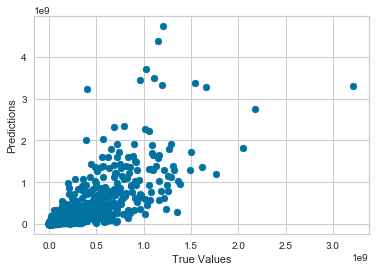

In [313]:
%matplotlib inline
plt.scatter((test['Revenue_Real']), np.exp(results.fittedvalues))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

### Let's try removing variables that are either not significant, may contribute to dummy variable trap, or may not be available prior to a movie's release. The featureSelectionMoviesData notebook stored in the same folder as this notebook also has some insight into the most correlated variables to a movie's revenue.

We'll remove some of the season variables, some of the genre variables, some of the company variables, and some of the rated variables. We'll also remove the awards features because, although they are important, they likely will only be available during or after a movie's run in theaters.

In [58]:
X_restricted = test[['constant', "Budget_Real_Log", 'Fall', 
'Rating_RT', 'Rating_IMDB', 'isCollection','Length',
'Genre_Drama', 'Genre_Thriller_Horror',
 'Genre_Romance',  'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros',   
'Revenue_Actor_Real_Log','Revenue_Director_Real_Log', 'Revenue_Writer_Real_Log'
]]
y = test["Revenue_Real_Log"]

In [59]:
model_restricted = sm.OLS(y, X_restricted)
results = model_restricted.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Revenue_Real_Log   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     129.3
Date:                Sun, 19 Aug 2018   Prob (F-statistic):               0.00
Time:                        16:14:57   Log-Likelihood:                -3096.2
No. Observations:                1879   AIC:                             6246.
Df Residuals:                    1852   BIC:                             6396.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
constant              

### Using the restricted set of features, let's create a train and test set of data to see how the regression performs.

We'll use sklearn instead of statsmodel here. We will print out the training and testing set's r_squared and mean absolute error in dollars.

In [60]:
# Split up the data with the 'train test split' method.
seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_restricted, y, test_size = 0.2, random_state=seed)

 Training set MAE: 100092356.68696138 dollars 
 Training set r_squared: 0.650804721253404 
 Testing set MAE: 87591598.46237479 dollars 
 Testing set r_squared: 0.6089023938859175 



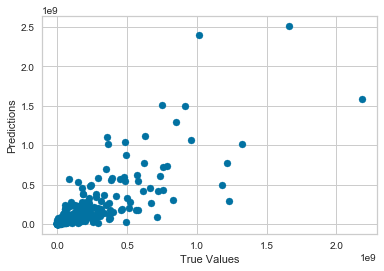

In [61]:
lm = LinearRegression()
lm.fit(X_train, y_train)

print(" Training set MAE:", mean_absolute_error(np.exp(y_train), np.exp(lm.predict(X_train))), "dollars", '\n',
      "Training set r_squared:", r2_score(y_train, lm.predict(X_train)), '\n',
      "Testing set MAE:", mean_absolute_error(np.exp(y_test), np.exp(lm.predict(X_test))), "dollars", '\n',
      "Testing set r_squared:", r2_score(y_test, lm.predict(X_test)), '\n',)

plt.scatter(np.exp(y_test), np.exp(lm.predict(X_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


### Now, try using Ridge, Lasso, and ElasticNet regressions to see if those models can restrict variables for us.

I am keeping all original features except those related to Awards. 

In [62]:
X = test[['constant', "Budget_Real_Log", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real_Log','Revenue_Director_Real_Log', 'Revenue_Writer_Real_Log']]

y = test['Revenue_Real_Log']
seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

 Training set MAE: 92277789.30495822 dollars 
 Training set r_squared: 0.6499964879848611 
 Testing set MAE: 80577860.32852244 dollars 
 Testing set r_squared: 0.5979746930346134 



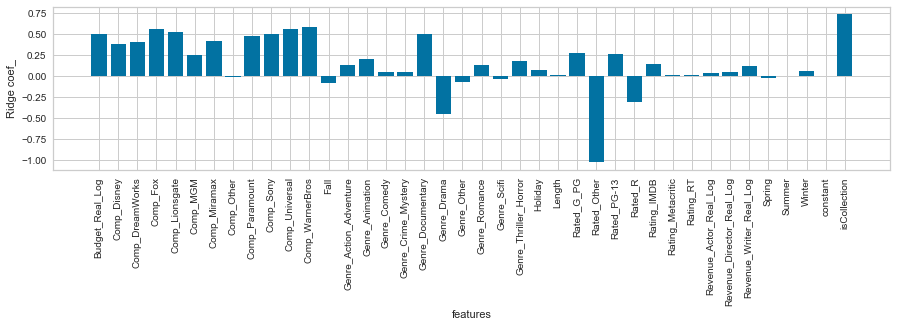

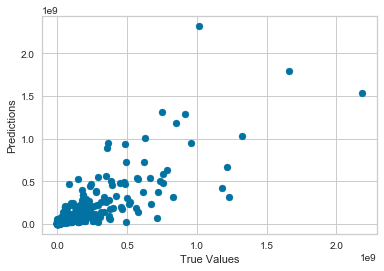

In [64]:
#Ridge Regression
ridgereg = RidgeCV(normalize=True) #alpha=.5,
ridgereg.fit(X_train, y_train)
ridgereg.score(X_test, y_test)
print(" Training set MAE:", mean_absolute_error(np.exp(y_train), np.exp(ridgereg.predict(X_train))), "dollars", '\n',
      "Training set r_squared:", r2_score(y_train, ridgereg.predict(X_train)), '\n',
      "Testing set MAE:", mean_absolute_error(np.exp(y_test), np.exp(ridgereg.predict(X_test))), "dollars", '\n',
      "Testing set r_squared:", r2_score(y_test, ridgereg.predict(X_test)), '\n',)
plt.figure(figsize=(15,3))
plt.bar(X.columns, ridgereg.coef_)
plt.xticks(rotation=90)
plt.xlabel("features")
plt.ylabel("Ridge coef_")
plt.show()

plt.scatter(np.exp(y_test), np.exp(ridgereg.predict(X_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

 Training set MAE: 91747934.19255832 dollars 
 Training set r_squared: 0.6501814537728309 
 Testing set MAE: 79769881.67609222 dollars 
 Testing set r_squared: 0.6020742590621214 



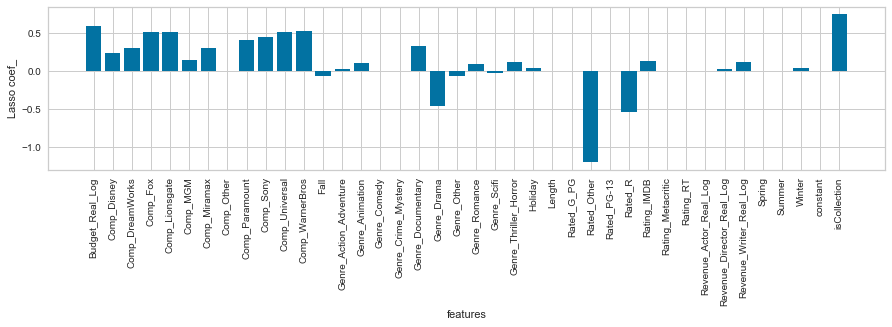

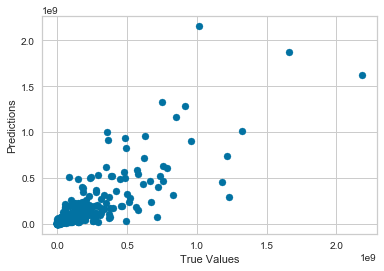

In [65]:
#Lasso Regression
lassoreg = LassoCV(normalize=True) #alpha=0.001,
lassoreg.fit(X_train, y_train)
lassoreg.score(X_test, y_test)
print(" Training set MAE:", mean_absolute_error(np.exp(y_train), np.exp(lassoreg.predict(X_train))), "dollars", '\n',
      "Training set r_squared:", r2_score(y_train, lassoreg.predict(X_train)), '\n',
      "Testing set MAE:", mean_absolute_error(np.exp(y_test), np.exp(lassoreg.predict(X_test))), "dollars", '\n',
      "Testing set r_squared:", r2_score(y_test, lassoreg.predict(X_test)), '\n',)
plt.figure(figsize=(15,3))
plt.bar(X.columns, lassoreg.coef_)
plt.xticks(rotation=90)
plt.xlabel("features")
plt.ylabel("Lasso coef_")
plt.show()

plt.scatter(np.exp(y_test), np.exp(lassoreg.predict(X_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

 Training set MAE: 88448778.45780806 dollars 
 Training set r_squared: 0.6459841683620554 
 Testing set MAE: 78347186.07629395 dollars 
 Testing set r_squared: 0.5917853911302374 



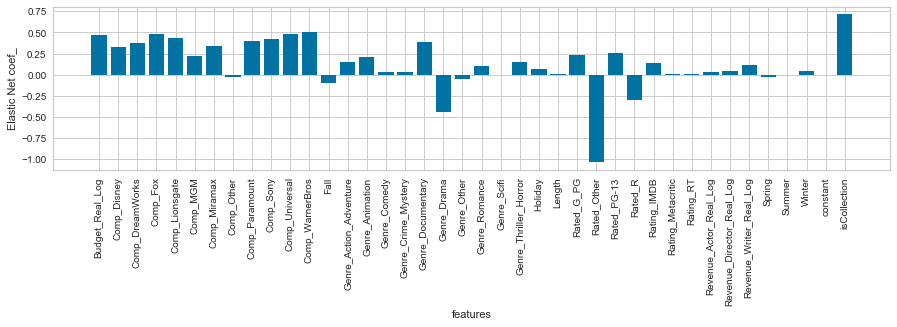

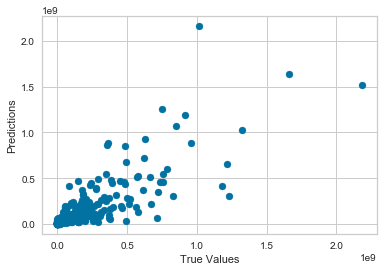

In [66]:
#Elastic Net Regression
elasticreg = ElasticNetCV(normalize=True) #alpha=.001,l1_ratio=.80, 
elasticreg.fit(X_train, y_train)
elasticreg.score(X_test, y_test)
print(" Training set MAE:", mean_absolute_error(np.exp(y_train), np.exp(elasticreg.predict(X_train))), "dollars", '\n',
      "Training set r_squared:", r2_score(y_train, elasticreg.predict(X_train)), '\n',
      "Testing set MAE:", mean_absolute_error(np.exp(y_test), np.exp(elasticreg.predict(X_test))), "dollars", '\n',
      "Testing set r_squared:", r2_score(y_test, elasticreg.predict(X_test)), '\n',)
plt.figure(figsize=(15,3))
plt.bar(X.columns, elasticreg.coef_)
plt.xticks(rotation=90)
plt.xlabel("features")
plt.ylabel("Elastic Net coef_")
plt.show()

plt.scatter(np.exp(y_test), np.exp(elasticreg.predict(X_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()



# Classification Models, part 1

We can also try to develop classes of movies in order to use classification models.  So, this section will look at whether we can predict movie profitability.  We will use a feature we created during the pre-processing step: "Profit_Bucket", which indicates whether a movie made less than its budget, same as its budget, twice its budget, three times, etc.  The classes are: <1x, [1-2x), [2-3x), [3-4x), [4-5x), and >=5x.  

In addition, we will create an additional feature called "Profit_Bucket_Binary" which will equal a 1 if the movie made at least twice its budget, and 0 if not.  We chose this threshold because in some of the literature regarding movie profitability, a rule-of-thumb some people follow is a movie likely makes a profit if it makes at least twice its production budget.  This is due to the extra costs of marketing, distribution, and other expenses.

Some of the codes to run models were taken from some labs we did in Dr. Bari's class and Dr. Bengfort's class.

### Create Profit Bucket Binary variable and set (X, y) train and test sets

We will create the new feature "Profit_Bucket_Binary", convert any "nan" in the historical cast/crew revenue columns to 0, and set the train and test sets that we will use for all the classification model testing. 

In [314]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in.  We could experiment with movies with revenue greater than $500,000, if 
#we choose to.
test = movies[(movies['Revenue_Real']>0)&(movies['Budget_Real']>0)&(movies['Length']>0)]

#Make binary variable for if movie made at least 2x budget
test['Profit_Bucket_Binary']=np.where(test['Profit_Bucket']=='<1x', 0, np.where(test['Profit_Bucket']=='[1-2x)', 
                        0, np.where(test['Profit_Bucket']=='[2-3x)', 1, np.where(test['Profit_Bucket']=='[3-4x)', 
                        1, np.where(test['Profit_Bucket']=='[4-5x)', 1, np.where(test['Profit_Bucket']=='>=5x', 1, ''))))))

#Put zero where null
test['Revenue_Actor_Real']=movies['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Director_Real']=movies['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Writer_Real']=movies['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)


C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

0    2539
1    1875
Name: Profit_Bucket_Binary, dtype: int64


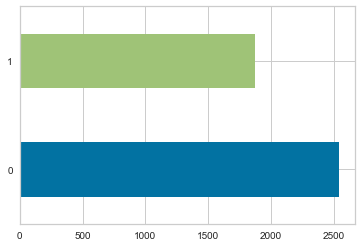

In [315]:
#Show distribution of profit bucket binary
print(test['Profit_Bucket_Binary'].value_counts())
test['Profit_Bucket_Binary'].value_counts().plot(kind='barh')

### As done in the Regression section, let's remove any Awards categories, even though they are good predictors of movie revenue.  

In [316]:
#Set X, y
X = test[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real']]
y = test["Profit_Bucket_Binary"]

seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

In [319]:
classifiers = [
    LogisticRegressionCV(random_state=1, cv=5),
    LogisticRegression(random_state=1),
    RandomForestClassifier(n_estimators=50, oob_score=True),
    XGBClassifier(), #Don't know why, but this model isn't working when using SMOTE.  
    BaggingClassifier(), 
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MultinomialNB(),
    GaussianNB(),
    #SVC(kernel='linear'),
    SVC(kernel='rbf'),
    #SVC(kernel='poly', degree=3),
    KNeighborsClassifier()]

### Line to run oversampling SMOTE method, if needed. 

In [320]:
#sm = SMOTE(random_state=12)
#X_train, y_train = sm.fit_sample(X_train, y_train)

LogisticRegressionCV [0.71428571 0.43050847]


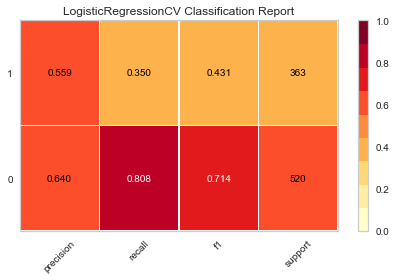

LogisticRegression [0.71319149 0.42978003]


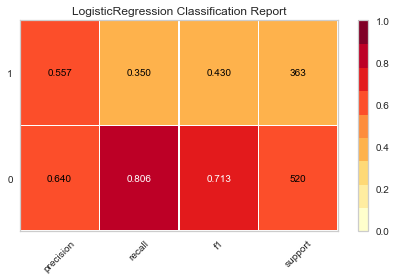

RandomForestClassifier [0.77828054 0.62934947]


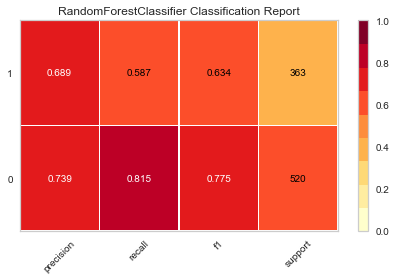

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier [0.76416819 0.61607143]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


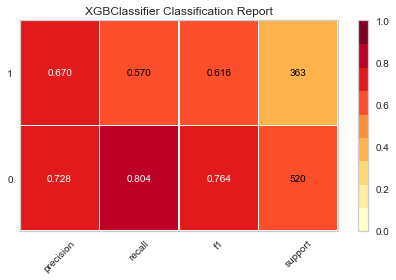

BaggingClassifier [0.75495495 0.58536585]


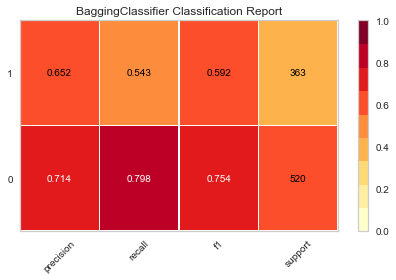

ExtraTreesClassifier [0.76147615 0.59541985]


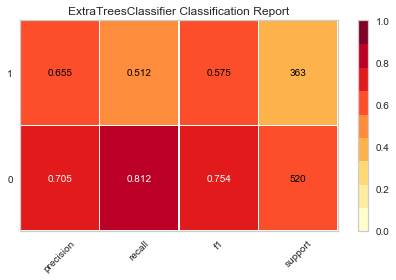

AdaBoostClassifier [0.75116496 0.61471861]


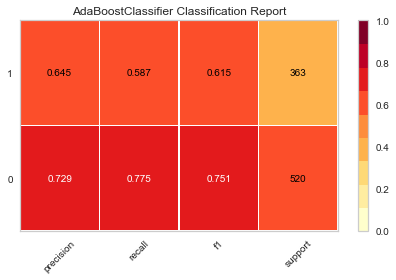

GradientBoostingClassifier [0.76584022 0.62333826]


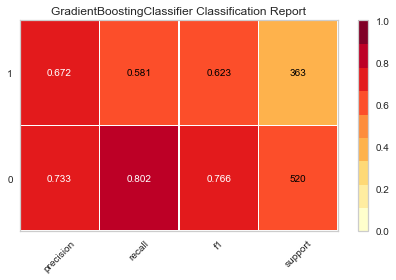

MultinomialNB [0.6967854  0.43252033]


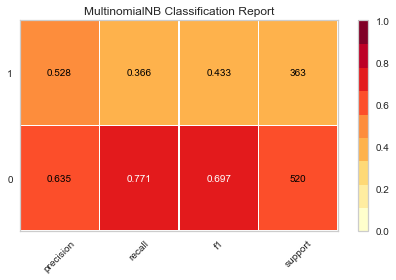

GaussianNB [0.74626866 0.34482759]


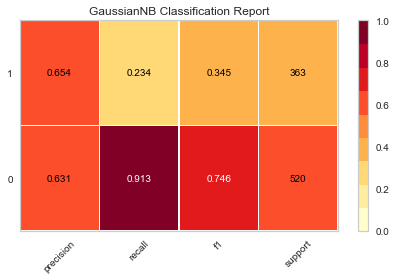

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC [0.74126871 0.        ]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


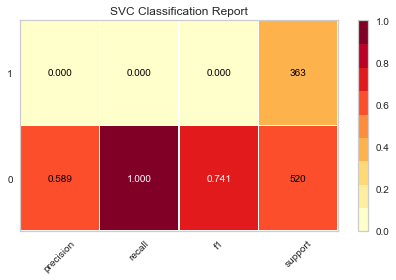

KNeighborsClassifier [0.64689527 0.44541485]


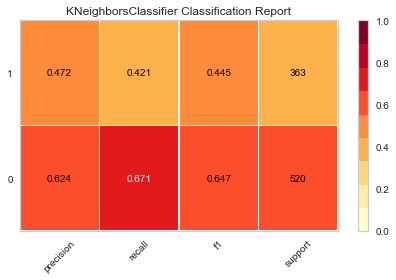

In [321]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    expected = y_test
    predicted = clf.predict(X_test)
    print(name, (f1_score(expected, predicted, average=None)))
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train, y_train)
    oz.score(X_test, y_test)
    oz.poof()
    
    #label_encoder = LabelEncoder()
    #yc = label_encoder.fit_transform(y)
    #oz = ROCAUC(clf, support=True, classes=label_encoder.classes_)
    #oz.fit(X_train, y_train)
    #oz.score(X_test, y_test)
    #oz.poof()
    
    #oz=FeatureImportances(clf)
    #oz.fit(X_train, y_train)
    #oz.poof()
    

In [ ]:
##Extra code to see most important features in random forest, log regression models
##Got this code to determine most important feature from here:
##https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
#feature_importances = pd.DataFrame(rf.feature_importances_,
#   index = X_train.columns,columns=['importance']).sort_values('importance',
#    ascending=False)
#(feature_importances.head(10))
#feature_importances = pd.DataFrame(log_reg.coef_.transpose(),
#   index = X_train.columns,columns=['importance']).sort_values('importance',
#    ascending=False)
#feature_importances.abs().sort_values(by='importance', ascending=False)
#(feature_importances.head(10))

# Classification Models, part 2

Let's run those same models on the original 6 classes we had in the "Profit_Bucket" feature to see which models can classify movies under multiple classes.  

### Create (X, y) train and test sets using "Profit_Bucket" feature

We set the set the train and test sets that we will use for all the classification model testing. 

<1x       1710
[1-2x)     829
[2-3x)     642
>=5x       632
[3-4x)     354
[4-5x)     247
Name: Profit_Bucket, dtype: int64


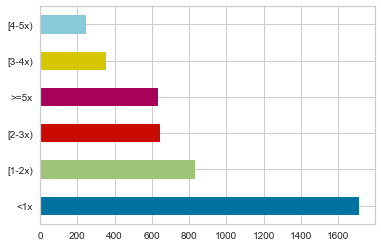

In [322]:
#Show distribution of profit bucket binary
print(test['Profit_Bucket'].value_counts())
test['Profit_Bucket'].value_counts().plot(kind='barh')

In [323]:
#Keep same X as original Classification models, but change y to "Profit_Bucket" instead of "Profit_Bucket_Binary"
y = test["Profit_Bucket"]

seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

### Line to run oversampling SMOTE method, if needed. 

In [324]:
#sm = SMOTE(random_state=12)
#X_train, y_train = sm.fit_sample(X_train, y_train)

LogisticRegressionCV [0.56596173 0.09022556 0.21301775 0.07142857 0.02985075 0.02985075]


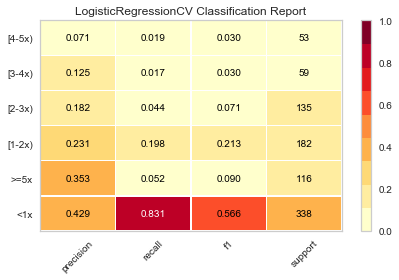

LogisticRegression [0.56740443 0.09022556 0.21364985 0.07142857 0.02985075 0.02985075]


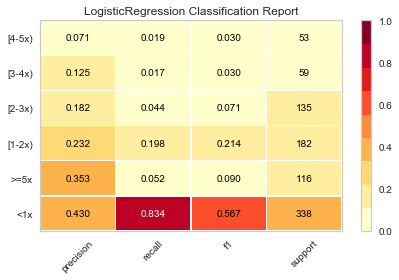

RandomForestClassifier [0.67203682 0.38818565 0.24503311 0.2300885  0.05479452 0.06779661]


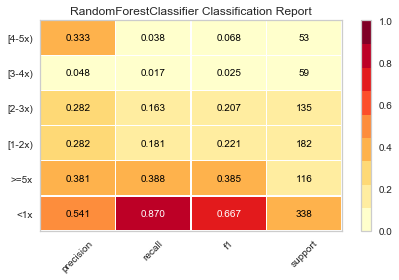

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier [0.67713004 0.42519685 0.23791822 0.19811321 0.05263158 0.12698413]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


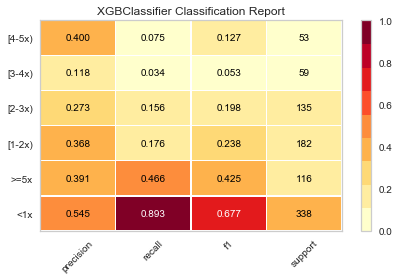

BaggingClassifier [0.64858491 0.33898305 0.23225806 0.18957346 0.13043478 0.11594203]


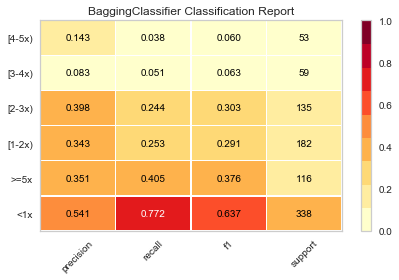

ExtraTreesClassifier [0.64971098 0.3490566  0.22295082 0.17757009 0.1        0.05714286]


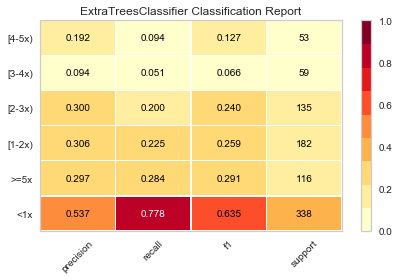

AdaBoostClassifier [0.64878049 0.36507937 0.22580645 0.12844037 0.02564103 0.25      ]


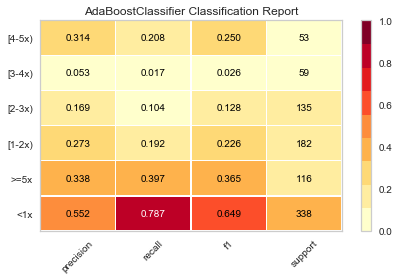

GradientBoostingClassifier [0.67529412 0.39506173 0.24832215 0.2081448  0.11627907 0.05882353]


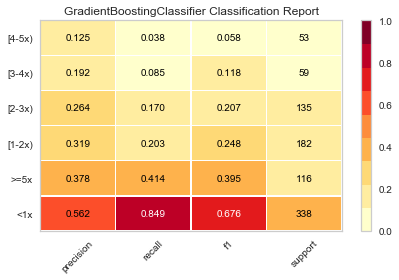

MultinomialNB [0.53799759 0.03100775 0.19076923 0.05464481 0.13793103 0.11267606]


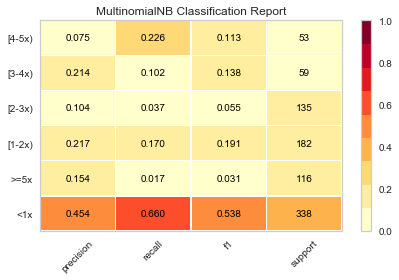

GaussianNB [0.60252672 0.01538462 0.18050542 0.12195122 0.         0.14893617]


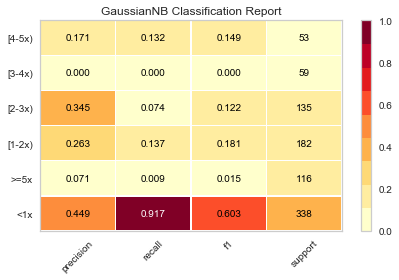

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC [0.55364455 0.         0.         0.         0.         0.        ]


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


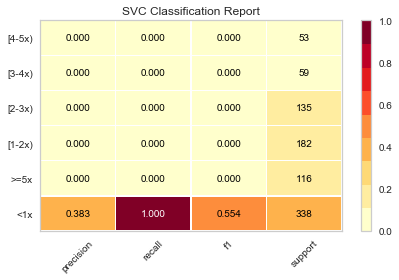

KNeighborsClassifier [0.55398037 0.1588785  0.20422535 0.04166667 0.04347826 0.02985075]


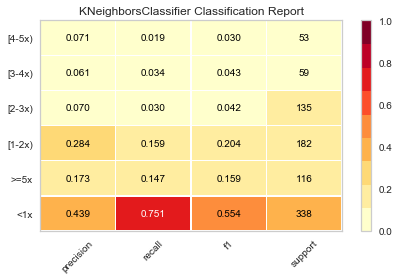

In [325]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    expected = y_test
    predicted = clf.predict(X_test)
    print(name, (f1_score(expected, predicted, average=None)))
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train, y_train)
    oz.score(X_test, y_test)
    oz.poof()